# 福字识别模型

## 定义一些提取特征的函数

In [1]:
from skimage import morphology, draw
import numpy as np
import matplotlib.pyplot as plt
import cv2


def readimage(t_name):
    image = cv2.imread(t_name, cv2.IMREAD_GRAYSCALE)
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image = 255 - image

    # 实施骨架算法
    skeleton = morphology.skeletonize(image)

    skeleton = 255 - skeleton
    image = 255 - image
    skeleton[skeleton != 255] = 0
    return image, skeleton


def features0(t_name):
    # img = cv2.imread(t_name,cv2.IMREAD_GRAYSCALE)
    # ret,img=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    _, img = readimage(t_name)

    sumleft = np.zeros((10))
    for i in range(10):
        for x in range(50):
            for y in range(500):
                if img[x + i * 50][y] == 0:
                    sumleft[i] += y

    sumright = np.zeros((10))
    for i in range(10):
        for x in range(50):
            for y in range(500):
                if img[x + i * 50][499 - y] == 0:
                    sumright[i] += y

    sumup = np.zeros((10))
    for i in range(10):
        for y in range(50):
            for x in range(500):
                if img[x][y + i * 50] == 0:
                    sumup[i] += x

    sumdown = np.zeros((10))
    for i in range(10):
        for y in range(50):
            for x in range(500):
                if img[499 - x][y + i * 50] == 0:
                    sumdown[i] += x

    feature2 = np.concatenate((sumleft, sumright, sumup, sumdown), axis=0)
    sumleft3 = np.zeros((10))
    for i in range(10):
        for x in range(50):
            flag = 0
            begin = 0
            for y in range(500):
                if img[x + i * 50][y] == 0 and flag == 0:
                    flag += 1
                if img[x + i * 50][y] == 255 and flag == 1:
                    flag += 1
                    begin = y
                if img[x + i * 50][y] == 0 and flag == 2:
                    flag += 1
                    sumleft3[i] += y - begin

    sumright3 = np.zeros((10))
    for i in range(10):
        for x in range(50):
            flag = 0
            begin = 0
            for y in range(500):
                if img[x + i * 50][499 - y] == 0 and flag == 0:
                    flag += 1
                if img[x + i * 50][499 - y] == 255 and flag == 1:
                    flag += 1
                    begin = y
                if img[x + i * 50][499 - y] == 0 and flag == 2:
                    flag += 1
                    sumright3[i] += y - begin

    sumup3 = np.zeros((10))
    for i in range(10):
        for y in range(50):
            flag = 0
            begin = 0
            for x in range(500):
                if img[x][y + i * 50] == 0 and flag == 0:
                    flag += 1
                if img[x][y + i * 50] == 255 and flag == 1:
                    flag += 1
                    begin = x
                if img[x][y + i * 50] == 0 and flag == 2:
                    flag += 1
                    sumup3[i] += x - begin

    sumdown3 = np.zeros((10))
    for i in range(10):
        for y in range(50):
            flag = 0
            begin = 0
            for x in range(500):
                if img[499 - x][y + i * 50] == 0 and flag == 0:
                    flag += 1
                if img[499 - x][y + i * 50] == 255 and flag == 1:
                    flag += 1
                    begin = x
                if img[499 - x][y + i * 50] == 0 and flag == 2:
                    flag += 1
                    sumdown3[i] += x - begin

    feature3 = np.concatenate((sumleft3, sumright3, sumup3, sumdown3), axis=0)
    feature23 = np.concatenate((feature2 / 25, feature3), axis=0)
    return feature23


import os
import numpy as np
from sklearn.cluster import KMeans
from feature import feature


class BoW:
    def __init__(self, PathofData, dim=50, method="sift", data_dim=128) -> None:
        self.dim = dim
        self.method = method
        self.data_dim = data_dim
        data = np.empty([0, data_dim])
        for i in PathofData:
            if method in ["sift", "surf", "orb"]:
                feat = feature(i, method, show=False)[1]
            elif method == "shi-tomasi":
                feat = np.squeeze(feature(i, method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                data = np.concatenate((data, feat), axis=0)
        kmeans = KMeans(n_clusters=dim, random_state=0, n_init="auto").fit(data)
        self.kmeans = kmeans

    def fit(self, PathofData):
        N = len(PathofData)
        Word = np.zeros([N, self.dim])
        for index, i in enumerate(PathofData):
            if self.method in ["sift", "surf", "orb"]:
                feat = feature(i, self.method, show=False)[1]
            elif self.method == "shi-tomasi":
                feat = np.squeeze(feature(i, self.method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                label = self.kmeans.predict(feat.astype(float))
                hist, _ = np.histogram(label, bins=range(self.dim + 1))
            else:
                hist = np.zeros((1, self.dim))
            if np.sum(hist) != 0:
                hist = hist / np.sum(hist)
            Word[index] = hist
        return Word

    def getSPM(self, PathofData, level):
        width = 500
        N = len(PathofData)
        Word = np.zeros([N, int(self.dim * (4**level - 1) / 3)])
        for index, i in enumerate(PathofData):
            counter = 0
            for l in range(level):
                x, y = 0, 0
                step = np.floor(width / 2**l).astype(int)
                for _ in range(2**l):
                    x = 0
                    for _ in range(2**l):
                        if self.method in ["sift", "surf", "orb"]:
                            feat = feature(
                                i,
                                self.method,
                                show=False,
                                x_start=x,
                                x_end=x + step,
                                y_start=y,
                                y_end=y + step,
                            )[1]
                        elif self.method == "shi-tomasi":
                            feat = feature(
                                i,
                                self.method,
                                show=False,
                                x_start=x,
                                x_end=x + step,
                                y_start=y,
                                y_end=y + step,
                            )
                            if feat is not None:
                                feat = np.squeeze(feat, axis=1)
                        else:
                            print("no method. ")
                            return []
                        if feat is not None:
                            label = self.kmeans.predict(feat.astype(float))
                            hist, _ = np.histogram(label, bins=range(self.dim + 1))
                            weight = 2 ** (l - level)
                            hist = hist * weight
                        else:
                            hist = np.zeros((1, self.dim))
                        Word[index][
                            counter * self.dim : (counter + 1) * self.dim
                        ] = np.copy(hist)
                        counter += 1
                        x = x + step
                    y = y + step
        return Word

## 定义一些常数

In [2]:
pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"
pathextratest = "./extratestdata/"
num_fu = len(os.listdir(pathfu))
num_notfu = len(os.listdir(pathnotfu))
num_test = len(os.listdir(pathtest))
num_extratest = len(os.listdir(pathextratest))
num_train = num_fu + num_notfu

t_name = [pathtest + "000{0}.png".format(i + 1) for i in range(9)]
t_name.append(pathtest + "0010.png")
ext_name = [pathextratest + str(i + 1) + ".png" for i in range(10)]
all = (
    [pathfu + i for i in os.listdir(pathfu)]
    + [pathnotfu + i for i in os.listdir(pathnotfu)]
    + t_name
    + ext_name
)
y = np.concatenate(
    (
        np.ones(num_fu),
        0 * np.ones(num_notfu),
        np.ones(5),
        0 * np.ones(5),
        np.ones(5),
        0 * np.ones(5),
    )
)
len(all), y.shape

(1580, (1580,))

## 获取视觉词袋特征（BOVW）

In [3]:
dim = 5 # 每个特征对应到视觉词袋的维数
Features = [("sift", 128), ("surf", 64), ("orb", 32), ("shi-tomasi", 2)]
BOWfeat = np.zeros((len(all), 0))
for method, data_dim in Features:
    BoWfu = BoW(
        all,
        method=method,
        data_dim=data_dim,
        dim=dim,
    )
    BOWfeat = np.concatenate(
        (
            BOWfeat,
            BoWfu.fit(all),
        ),
        axis=1,
    )
BOWfeat.shape

(1580, 20)

## 提取汉字特征

外轮廓特征、内轮廓特征已经并在一起了

In [4]:
import multiprocessing

char_feat = np.zeros((len(all), 80))
num_processes = multiprocessing.cpu_count() - 2  # 使用核心数
pool = multiprocessing.Pool(processes=num_processes)  # 实例化进程池
result = pool.map(features0, all)
for i in range(len(result)):
    char_feat[i] = result[i]

## 拆分训练集、验证集、测试集

In [5]:
data = np.concatenate((char_feat, BOWfeat), axis=1)  # 特征向量
print(data.shape)
X = data

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X[:num_train, :], y[:num_train], test_size=0.2, random_state=42
)
X_test = X[num_train : num_train + num_test]
y_test = y[num_train : num_train + num_test]
X_exttest = X[-10:, :]
y_exttest = y[-10:]

(1580, 100)


## 定义AdaBoost分类器

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_estimators = 200  ##超参

clf = make_pipeline(
    StandardScaler(), AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=200, random_state=0))])

## 网格调参

In [7]:
from sklearn.model_selection import GridSearchCV

# 参数范围
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  
    'learning_rate': [0.1, 0.5, 1.0]  
}

clf=AdaBoostClassifier(random_state=0)

# 网格搜索，5折交叉验证
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和对应的评分
print("最佳参数组合: ", grid_search.best_params_)
print("最佳F1得分: ", grid_search.best_score_)


最佳参数组合:  {'learning_rate': 1.0, 'n_estimators': 400}
最佳F1得分:  0.9497728973920182


In [8]:
clf=grid_search.best_estimator_

## 评价验证集分类效果（F1-macro）

In [15]:
from sklearn.metrics import f1_score

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f1_score(y_val, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

0.925215723873442


array([[296,   0],
       [  4,  12]])

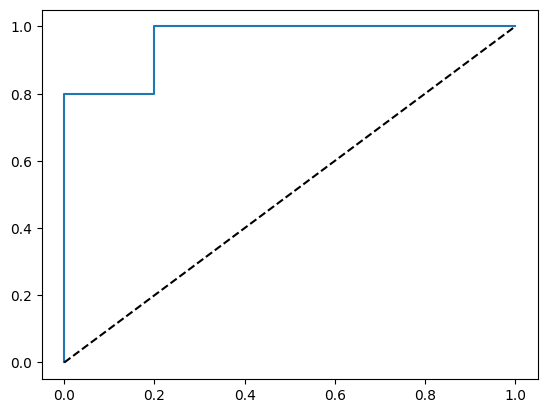

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

probalilities = clf.predict_proba(X_test)[:, 1]  # 假设为正类的概率
fpr, tpr, thresholds = roc_curve(y_test, probalilities)

# 计算AUC值
auc = roc_auc_score(y_test, probalilities)

# 绘制ROC曲线
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.show()

In [10]:
from sklearn.metrics import classification_report

print('分类报告:') 	#包括准确率、召回率、f1得分等
print(classification_report(y_val, y_pred))

分类报告:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       296
         1.0       1.00      0.75      0.86        16

    accuracy                           0.99       312
   macro avg       0.99      0.88      0.93       312
weighted avg       0.99      0.99      0.99       312



## 评价测试集分类效果（F1-macro）

In [11]:
clf.fit(X[:num_train, :], y[:num_train])
y_pred = clf.predict(X_test)
print(y_pred)
print(f1_score(y_test, y_pred, average="macro"))
print(confusion_matrix(y_pred, y_test))

[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
1.0
[[5 0]
 [0 5]]


In [12]:
from sklearn.metrics import classification_report

print('分类报告:') 	#包括准确率、召回率、f1得分等
print(classification_report(y_test, y_pred))

分类报告:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## 尝试单分类模型效果

In [13]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest


def intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    a = np.sum(minima)
    return a


def kernal(X1, X2):  # 直方图交叉核
    result = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            result[i][j] = intersection(X1[i, :], X2[j, :])
    return result


from sklearn.svm import OneClassSVM

f1 = []
for nu in np.linspace(0.01, 0.99, 30):
    for kernel in ["linear", "poly", "rbf", "sigmoid", kernal]:
        oneclassclf = make_pipeline(OneClassSVM(nu=nu, kernel=kernel))
        oneclassclf.fit(X[:num_fu, :])

        y_pred = oneclassclf.predict(X[:num_train, :])
        y_val_new = np.copy(y[:num_train])
        y_val_new[y_val_new == 0] = -1
        f1s = f1_score(y_val_new, y_pred, average="macro")
        f1.append(f1s)

        from sklearn.metrics import f1_score

        y_pred = oneclassclf.predict(X_test)

        f1_test = f1_score(
            np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro"
        )
        print(f"f1_val:{f1s}, nu:{nu}, kernel:{kernel}, f1_test:{f1_test}")

        from sklearn.metrics import confusion_matrix

        confusion_matrix(np.concatenate((np.ones(5), -np.ones(5))), y_pred)
print(max(f1))
print(f1)

f1_val:0.19007727860910978, nu:0.01, kernel:linear, f1_test:0.5238095238095238
f1_val:0.19007727860910978, nu:0.01, kernel:poly, f1_test:0.5238095238095238
f1_val:0.7672206367858542, nu:0.01, kernel:rbf, f1_test:0.8000000000000002
f1_val:0.19007727860910978, nu:0.01, kernel:sigmoid, f1_test:0.5238095238095238
f1_val:0.43396316102198457, nu:0.01, kernel:<function kernal at 0x7fbe31112290>, f1_test:0.6703296703296704
f1_val:0.24694766273496735, nu:0.04379310344827586, kernel:linear, f1_test:0.6703296703296704
f1_val:0.25551627271076555, nu:0.04379310344827586, kernel:poly, f1_test:0.6703296703296704
f1_val:0.7618204398105519, nu:0.04379310344827586, kernel:rbf, f1_test:0.8000000000000002
f1_val:0.2416468144890355, nu:0.04379310344827586, kernel:sigmoid, f1_test:0.6703296703296704
f1_val:0.43396316102198457, nu:0.04379310344827586, kernel:<function kernal at 0x7fbe31112290>, f1_test:0.6703296703296704
f1_val:0.29426770391921236, nu:0.07758620689655171, kernel:linear, f1_test:0.67032967032

## 比较监督分类器与单分类器在额外测试集上的性能

In [14]:
print("监督学习模型")
clf.fit(X[:num_train, :], y[:num_train])
y_pred = clf.predict(X_exttest)
print(y_pred)
print(f1_score(y_exttest, y_pred, average="macro"))
print(confusion_matrix(y_pred, y_exttest))

print("单分类模型")
oneclassclf = make_pipeline(
    OneClassSVM(nu=0.2803448275862069, kernel="rbf")
)  ## 从上得到的最优模型
oneclassclf.fit(X[:num_fu, :])
y_pred = oneclassclf.predict(X_exttest)
print(y_pred)
print(f1_score(np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro"))
print(confusion_matrix(y_pred, np.concatenate((np.ones(5), -np.ones(5)))))

监督学习模型
[1. 0. 0. 1. 0. 1. 0. 1. 1. 0.]
0.4000000000000001
[[2 3]
 [3 2]]
单分类模型
[ 1 -1  1 -1 -1  1 -1 -1 -1 -1]
0.5833333333333333
[[4 3]
 [1 2]]
